# Develop the VircamISRTask
In this notebook we experiment with implementing the CASU confidence maps to provide a variance plane which accounts for the exposure maps and bad pixels. This information is included in the CASU confidence maps. These are defined such that:

variance = image * 100/confidence

Most of the confidence are ~100 across the centre with edge confidence going down to zero and some bad pixels with lower confidence.

We need to develop a new ISR task to implement the confidence maps in the variance plane. We are inheriting from the isrTask in:

https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

There are many ways to implement this. I am concentrating on modifying the parent class as little as possible so that any changes made to future versions will be inherited and function. I merely want to overwrite the variance plane. I am doing this by overwriting the run method. It would also be possible to overwrite the updateVariance method instead which might be important if furture methods depend on the variance plane.

Some care has to be taken with modifications in place. The LSST classes are built to be modifed in place. that means that functions do not return modifed copies but instead do not return anything but update the original object.

## The variance plane

The basic variance plane using the standard pipeline is given by:

```python
variance = image / gain + readNoise ** 2
```

Following discussions with Mike Irwin the variance plane should infact be given by:

```python
variance = (1/n_eff) * ((1 + n_eff)/n_eff * readNoise ** 2 + (background/n_eff + image) / gain)
```

where the effective number of exposures n_eff is given in terms of the number of exposures and confidence map:

```python
n_eff = n * confidence/100
```readNoise ** 2

### gain convention
The convention in the LSST Science Pipelines is to define gain in ADU per electron but in the CASU convention it is defined by electrons per ADU so we adopt the LSST Science Pipelines definition and invert the values in camera.yaml file compared to the public CASU values.

In [3]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g7ae64ea4b3+059940673e 	current w_2022_03 w_latest setup
obs_vista             23.0.0-1   	current setup


In [4]:
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import numpy as np

In [5]:
# For DC2 gen3, these are the only optoins
repo = './data'
collection = 'videoTest'

# Use the butler to get the calexp
butler = Butler(repo)


registry = butler.registry
for c in sorted(registry.queryCollections()):
    print(c)

VIRCAM/calib
VIRCAM/calib/unbounded
VIRCAM/raw/all
refcats
skymaps
videoTest


In [43]:
# Define the dataId
dataId = {'instrument':'VIRCAM','physical_filter': 'VIRCAM-Ks', 'exposure': 658653, 'detector': 1}
butler = Butler(repo, collections='VIRCAM/raw/all')
ccdExposure = butler.get('raw', **dataId)

Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/VIRCAM/raw/all/raw/20121123/658653/raw_VIRCAM_VIRCAM-Ks_658653_ccd1_VIRCAM_raw_all.fit: 'ESO INS THERMAL AMB MEAN not found'
Ignoring Error calculating property 'altaz_begin' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/VIRCAM/raw/all/raw/20121123/658653/raw_VIRCAM_VIRCAM-Ks_658653_ccd1_VIRCAM_raw_all.fit: '/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/VIRCAM/raw/all/raw/20121123/658653/raw_VIRCAM_VIRCAM-Ks_658653_ccd1_VIRCAM_raw_all.fit(658653): Unable to determine AltAz of science observation'


detectorId 1 type <class 'int'>
detectorId 1 type <class 'int'>


In [42]:
# Define the dataId
dataId = {'instrument':'VIRCAM','physical_filter': 'VIRCAM-Ks', 'exposure': 658653, 'detector': 1}
butler = Butler(repo, collections='videoTest')
confidence = butler.get('confidence', **dataId)

Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/videoTest/confidence/20121123/658653/confidence_VIRCAM_VIRCAM-Ks_658653_ccd1_videoTest.fit: 'ESO INS THERMAL AMB MEAN not found'
Ignoring Error calculating property 'altaz_begin' using translator <class 'lsst.obs.vista.translators.vircam.VircamTranslator'> and file /Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/videoTest/confidence/20121123/658653/confidence_VIRCAM_VIRCAM-Ks_658653_ccd1_videoTest.fit: '/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu4/dmu4_Example/data/videoTest/confidence/20121123/658653/confidence_VIRCAM_VIRCAM-Ks_658653_ccd1_videoTest.fit(658653): Unable to determine AltAz of science observation'


detectorId 1 type <class 'int'>
detectorId 1 type <class 'int'>


In [9]:
from lsst.ip.isr import isrFunctions

In [10]:
#The standard updateVariance function
isrFunctions.updateVariance?

Signature: isrFunctions.updateVariance(maskedImage, gain, readNoise)
Docstring:
Set the variance plane based on the image plane.

Parameters
----------
maskedImage : `lsst.afw.image.MaskedImage`
    Image to process.  The variance plane is modified.
gain : scalar
    The amplifier gain in electrons/ADU.
readNoise : scalar
    The amplifier read nmoise in ADU/pixel.
File:      ~/Documents/github/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/ip_isr/g9cb75138f3+66a1f77fa1/python/lsst/ip/isr/isrFunctions.py
Type:      function


## Develop the VircamIsrTask

All the classes will be written in the following cell with requisite imports to allow copy pasting to the python file python/lsst/obs/vista/vircamIsrTask.py

In [52]:
#imports required by task definition - this cell should contain all the Python for the task 
#such that it can be directly copied to obs_vista/python/lsst/obs/vista/vircamIsrTask.py
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig, IsrTaskConnections
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
import lsst.pipe.base.connectionTypes as cT
from lsst.utils.timer import timeMethod
import lsst.geom as geom
import numpy as np

__all__ = ["VircamIsrConfig", "VircamIsrTask", "VircamIsrTaskConnections"]


class VircamIsrTaskConnections(IsrTaskConnections):
    confidence = cT.PrerequisiteInput(
        name="confidence",
        doc="Confidence map associated with input exposure to process.",
        storageClass="Exposure",
        dimensions=["instrument", "exposure", "detector"],
    )
    def __init__(self, *, config=None):
        super().__init__(config=config)

        if config.doVircamConfidence is not True:
            self.prerequisiteInputs.discard("confidence")

class VircamIsrConfig(IsrTaskConfig,
        #pipelineConnections=IsrTaskConnections):
        pipelineConnections=VircamIsrTaskConnections):
    doVircamConfidence = pexConfig.Field(
        dtype=bool,
        doc="Apply the CASU VISTA confidence map to the exposure variance image if available.",
        default=False,
    )
    
    updateVircamBBox = pexConfig.Field(
        dtype=bool,
        doc="Correct the BBox of the exposure to account for dithering for stack.",
        default=False,
    )
    
    def setDefaults(self):
        IsrTask.ConfigClass.setDefaults(self)

class VircamIsrTask(IsrTask):
    """Load a CASU confidence map and apply it to the variance plane

    This is used to retarget the `isr` subtask in `ProcessCcdTask` when you prefer to use
    the community pipeline instead of the LSST software stack to perform ISR on DECam images.
    """
    ConfigClass = VircamIsrConfig
    _DefaultName = "isr"
 
    @timeMethod
    def run(self, ccdExposure, *, camera=None, bias=None, linearizer=None,
            crosstalk=None, crosstalkSources=None,
            dark=None, flat=None, ptc=None, bfKernel=None, bfGains=None, defects=None,
            fringes=pipeBase.Struct(fringes=None), opticsTransmission=None, filterTransmission=None,
            sensorTransmission=None, atmosphereTransmission=None,
            detectorNum=None, strayLightData=None, illumMaskedImage=None,
            isGen3=False,
            confidence=None #additional argument passed to overwritten method
            ):
        """Execute the parent run method and apply confidence and gain if requested"""
        self.log.info("VISTA: Running vircamIsrTask." )

        
        if self.config.updateVircamBBox:
            self.vircamUpdateDetector(ccdExposure)
        
        output= super().run(ccdExposure, camera=camera, bias=bias, linearizer=linearizer,
            crosstalk=crosstalk, crosstalkSources=crosstalkSources,
            dark=dark, flat=flat, ptc=ptc, bfKernel=bfKernel, bfGains=bfGains, defects=defects,
            fringes=fringes, opticsTransmission=opticsTransmission, filterTransmission=filterTransmission,
            sensorTransmission=sensorTransmission, atmosphereTransmission=atmosphereTransmission,
            detectorNum=detectorNum, strayLightData=strayLightData, illumMaskedImage=illumMaskedImage,
            isGen3=isGen3,
            #additional argument not passed to parent method
            )
        
      
        #Make the VISTA specific variance plane
        if self.config.doVircamConfidence and confidence is not None:
            self.vircamUpdateVariance(output.exposure,confidence=confidence)
        if self.config.doVircamConfidence and confidence is None:
            self.log.info("VISTA: doVircamConfidence is True but no confidence map is available." )

        # output.outputExposure=output.exposure
        return output

    def vircamUpdateVariance(self, exposure, *, confidence=None):
        """Make a VIRCAM CASU based variance plane from the confidence map

        Parameters
        ----------
        exposure : `lsst.afw.image.Exposure`
            The exposure after running parent ISR methods.  The
            exposure is modified by this method.

        confidence : `lsst.afw.image.Exposure`
            The CASU confidence map
        """
       
        expNum=exposure.getInfo().getMetadata().getAsInt('NICOMB')
        sky=exposure.getInfo().getMetadata().getAsDouble('SKYLEVEL')
        amp=exposure.getDetector().getAmplifiers()[0]
        gain=amp.getGain()
        readNoise=amp.getReadNoise()
            
        var = exposure.getVariance()
        img = exposure.getImage()
        #cut the cropped region out of the confidence map
        conf=confidence.image.array[:var.array.shape[0],:var.array.shape[1]]
        #flip the confidence map to account for image flipping
        #NOTE: Flipping must be consistent with camera.yaml and rawFormatter
        conf=np.flipud(np.fliplr(conf))
        effNum=expNum*conf/100 #effective exposure number
        #Apply CASU variance from confidence, image, sky in stages to optimise memory use
        var.array=(1+effNum)/effNum
        var.array*=readNoise**2
        var.array+=img.array/gain
        var.array+=sky/(effNum*gain)
        var.array/=effNum

        self.log.info("VISTA: Effective exposure number reset using CASU confidence map." )
        
        #Now lets modify the mask using the low confidence pixels
        mask=exposure.getMask()
        #Mask all pixels with confidence below 20 as bad
        mask.array[conf<20]|=mask.getPlaneBitMask('BAD')
        self.log.info("VISTA: Pixels with confidence <20% flagged BAD.")



    def vircamUpdateDetector(self, ccdExposure):
        """Update the detector bounding boxes to match the image

        VIRCAM CASU stacks are different sizes depending on 
 
        Parameters
        ----------
        ccdExposure : `lsst.afw.image.Exposure`
            The exposure to modify the bounding boxes for.

        """
        detector=ccdExposure.getDetector()
        #update BBox to image size
        BBox = geom.Box2I(geom.Point2I(0, 0), geom.Extent2I(
            ccdExposure.getImage().array.shape[1],
            ccdExposure.getImage().array.shape[0]
        ))
        self.log.info("VISTA: Updating detector BBox to contain full stacked image [{},{}].".format(
            ccdExposure.getImage().array.shape[1],
            ccdExposure.getImage().array.shape[0]) )
        detBuilder=detector.rebuild()
        detBuilder.setBBox(BBox)
        amplifier=detBuilder.getAmplifiers()[0]
        #ampBuilder=amplifier.rebuild()
        amplifier.setRawBBox(BBox)
        amplifier.setBBox(BBox)
        amplifier.setRawDataBBox(BBox)
        ccdExposure.setDetector(detBuilder.finish())

        
        
        




In [53]:
# After this is just for quick testing the classes - do not copy to 
config = VircamIsrTask.ConfigClass()

config.doBias=False
config.doDark=False
config.doFlat=False
config.doDefect=False

config.updateVircamBBox=True
config.doVircamConfidence=True

config.doOverscan=False

# trim out non-data regions?
config.assembleCcd.doTrim=False

# Setting this to false leaves the edge pixels in but masks them as edge
#Turning it off seems to break the wcs possibly because it isn't applying the flipping
# Assemble amp-level exposures into a ccd-level exposure?
config.doAssembleCcd=True

config.doAssembleIsrExposures = True

config.doSaturationInterpolation = False

# Mask saturated pixels? NB: this is totally independent of the interpolation option - this is ONLY setting the bits in the mask. To have them interpolated make sure doSaturationInterpolation=True
config.doSaturation=False

#config.doFringe=False

config.doSuspect=True
# config.suspectMaskName = "SUSPECT"
# config.numEdgeSuspect = 0

# Should we set the level of all BAD patches of the chip to the chip's average value?
config.doSetBadRegions=False

VircamIsrTaskInstance = VircamIsrTask(config=config)
result = VircamIsrTaskInstance.run(ccdExposure.clone(),confidence=confidence.clone()) # use clones to leave originals unchanged

No rough magnitude zero point defined for filter VIRCAM-Ks.
/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_83267/2196036717.py:119: RuntimeWarning: divide by zero encountered in true_divide
  var.array=(1+effNum)/effNum
/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_83267/2196036717.py:122: RuntimeWarning: divide by zero encountered in true_divide
  var.array+=sky/(effNum*gain)


In [45]:
result.exposure.image.array.shape

(2127, 2105)

In [46]:
mI=result.exposure.getMaskedImage()
mI.getVariance().array.shape

(2127, 2105)

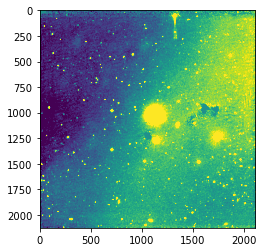

In [47]:
plt.imshow(result.exposure.image.array,
           vmin=np.percentile(result.exposure.image.array.flatten(),10),
           vmax=np.percentile(result.exposure.image.array.flatten(),90))

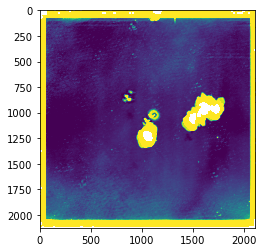

In [48]:
arr=result.exposure.getVariance().array
plt.imshow(arr,
           vmin=np.percentile(arr.flatten(),10),
           vmax=np.percentile(arr.flatten(),85))

In [49]:
result.exposure.getVariance().array.shape

(2127, 2105)

In [56]:
result.exposure.getMask().array

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

(array([ 35647.,  36586.,  40827.,  44998.,  49854.,  53956.,  58508.,
         62517.,  67516.,  71401.,  76047.,  79940.,  84286.,  88231.,
         91442.,  94990.,  98078., 101423., 104424., 106330., 109308.,
        111277., 112596., 114115., 135380., 125579., 115384., 114282.,
        113869., 112916., 110781., 108016., 104933., 101507.,  97497.,
         94528.,  89033.,  85038.,  79615.,  74372.,  69106.,  64180.,
         58750.,  53695.,  48747.,  43613.,  39681.,  35459.,  31389.,
         30281.]),
 array([13037.255 , 13037.95  , 13038.6455, 13039.341 , 13040.037 ,
        13040.732 , 13041.428 , 13042.123 , 13042.818 , 13043.514 ,
        13044.209 , 13044.905 , 13045.601 , 13046.296 , 13046.991 ,
        13047.687 , 13048.382 , 13049.077 , 13049.773 , 13050.469 ,
        13051.164 , 13051.859 , 13052.555 , 13053.25  , 13053.945 ,
        13054.641 , 13055.337 , 13056.032 , 13056.728 , 13057.423 ,
        13058.118 , 13058.813 , 13059.509 , 13060.205 , 13060.9   ,
        

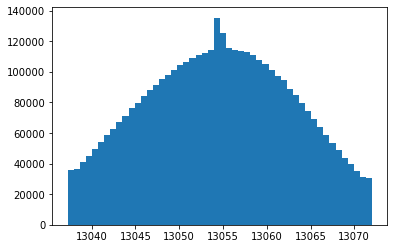

In [50]:
plt.hist(result.exposure.image.array.flatten(),bins=50,
         range=[np.percentile(result.exposure.image.array.flatten(),5 ),
               np.percentile(result.exposure.image.array.flatten(),95 )])